# Full Example
THe idea with this NB is to do the same as the pymc_prophet_example NB but do everything (holidays, regressors etc...) in a single example and compare pymc_prohet with prophet. Then we will use this to build the Bayesian PyMC component.

In [ ]:
from pymcprophet.model import BayesTS, BayesTSConfig
from prophet import Prophet

import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")


Importing plotly failed. Interactive plots will not work.


Running on PyMC v5.20.1


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df['ds'] = pd.to_datetime(df['ds'])

## Holidays
These are user defined. We will also add auto US ones.

In [3]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

## Regressor
Custom dataset for Sundays during the NFL Season.

In [4]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

## Modelling

In [5]:
train_df = df.query("ds.dt.year <= 2014")
test_df = df.query("ds.dt.year > 2014")

### PyMC

In [6]:
ts_config = BayesTSConfig()
ts_model = BayesTS(ts_config)
ts_model.add_holiday_country("US")
ts_model.add_holiday(holidays)
ts_model.add_regressor("nfl_sunday", mode="additive")

ts_model.assign_model_matrix(train_df)

In [7]:
ts_model.model_df[["y_trans","t"] + ts_model.model_spec.get_bayes_feature_cols()]

,y_trans,t,playoff,playoff_lag_1,superbowl,superbowl_lag_1,nfl_sunday,christmas_day,christmas_day_observed,columbus_day,...,yearly_cos_7,yearly_cos_8,yearly_cos_9,yearly_cos_10,weekly_sin_1,weekly_sin_2,weekly_sin_3,weekly_cos_1,weekly_cos_2,weekly_cos_3
0,0.746552,0.000000,0,0,0,0,0,0,0,0,...,-0.908042,-0.998981,-0.942120,-0.745872,-4.338837e-01,7.818315e-01,-9.749279e-01,-0.900969,0.623490,-0.222521
1,0.663171,0.000388,0,0,0,0,0,0,0,0,...,-0.851148,-0.983343,-0.982552,-0.848883,-9.749279e-01,4.338837e-01,7.818315e-01,-0.222521,-0.900969,0.623490
2,0.637023,0.000776,0,0,0,0,0,0,0,0,...,-0.781927,-0.949111,-0.999480,-0.926834,-7.818315e-01,-9.749279e-01,-4.338837e-01,0.623490,-0.222521,-0.900969
3,0.628367,0.001164,0,0,0,0,0,0,0,0,...,-0.701382,-0.896932,-0.992498,-0.977426,5.505235e-14,1.101047e-13,1.984146e-12,1.000000,1.000000,1.000000
4,0.614441,0.001552,0,0,0,0,0,0,0,0,...,-0.610679,-0.827793,-0.961774,-0.999166,7.818315e-01,9.749279e-01,4.338837e-01,0.623490,-0.222521,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,0.608278,0.998448,0,0,0,0,0,0,0,0,...,0.806736,0.750154,0.687457,0.619157,9.749279e-01,-4.338837e-01,-7.818315e-01,-0.222521,-0.900969,0.623490
2518,0.652928,0.998836,0,0,0,0,1,0,0,0,...,0.871878,0.833777,0.791221,0.744438,4.338837e-01,-7.818315e-01,9.749279e-01,-0.900969,0.623490,-0.222521
2519,0.680962,0.999224,0,0,0,0,0,0,0,0,...,0.924393,0.901634,0.876058,0.847744,-4.338837e-01,7.818315e-01,-9.749279e-01,-0.900969,0.623490,-0.222521
2520,0.647080,0.999612,0,0,0,0,0,0,0,0,...,0.963520,0.952442,0.939938,0.926025,-9.749279e-01,4.338837e-01,7.818315e-01,-0.222521,-0.900969,0.623490


In [8]:
# additive priors and matrix
additive_feature_dict = ts_model.model_spec.get_bayes_feature_dict(mode="additive")
additive_feature_names = list(additive_feature_dict.keys())
additive_prior_mus = np.array([feature.prior_params["mu"] for feature in additive_feature_dict.values()])
additive_prior_sigmas = np.array([feature.prior_params["sigma"] for feature in additive_feature_dict.values()])
X_additive = ts_model.model_df[additive_feature_names].to_numpy()

# multiplicative priors and matrix
multiplicative_feature_dict = ts_model.model_spec.get_bayes_feature_dict(mode="multiplicative")
multiplicative_feature_names = list(multiplicative_feature_dict.keys())
multiplicative_prior_mus = np.array([feature.prior_params["mu"] for feature in multiplicative_feature_dict.values()])
multiplicative_prior_sigmas = np.array([feature.prior_params["sigma"] for feature in multiplicative_feature_dict.values()])
X_multiplicative = ts_model.model_df[multiplicative_feature_names].to_numpy()

y = ts_model.model_df["y_trans"].to_numpy()
t = ts_model.model_df["t"].to_numpy()

coords = {
    "additive_features": additive_feature_names,
    "multiplicative_features": multiplicative_feature_names,
    "time": ts_model.model_df["ds"],
}
forecast_model = pm.Model(coords=coords)

with forecast_model:
    # trend(t) applies to k(t-m),
    k = pm.Normal("k", mu=0, sigma=5)
    m = pm.Normal("m", mu=0, sigma=5)
    trend = pm.Deterministic("trend", k * t + m, dims="time")

    # additive terms
    additive_predictors = pm.Data("additive_predictors", X_additive, dims=["time", "additive_features"])
    beta_additive = pm.Normal(
        "beta_additive",
        mu=additive_prior_mus,
        sigma=additive_prior_sigmas,
        dims="additive_features",
    )
    additive_terms = additive_terms = pm.Deterministic(
        "additive_terms",
        additive_predictors @ beta_additive,
        dims="time",
    )

    # multiplicative_terms
    multiplicative_predictors = pm.Data("multiplicative_predictors", X_multiplicative, dims=["time", "multiplicative_features"])
    beta_multiplicative = pm.Normal(
        "beta_multiplicative",
        mu=multiplicative_prior_mus,
        sigma=multiplicative_prior_sigmas,
        dims="multiplicative_features",
    )
    multiplicative_terms = multiplicative_terms = pm.Deterministic(
        "multiplicative_terms",
        multiplicative_predictors @ beta_multiplicative,
        dims="time",
    )

    # predictions
    y_pred = pm.Deterministic("y_pred", trend * (1 + multiplicative_terms) + additive_terms, dims="time")

    # observation
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.5)
    y_obs = pm.Normal("y_obs", mu=y_pred, sigma=sigma_obs, observed=y, dims="time")

    # prior predictive sample
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [beta_additive, beta_multiplicative, k, m, sigma_obs, y_obs]


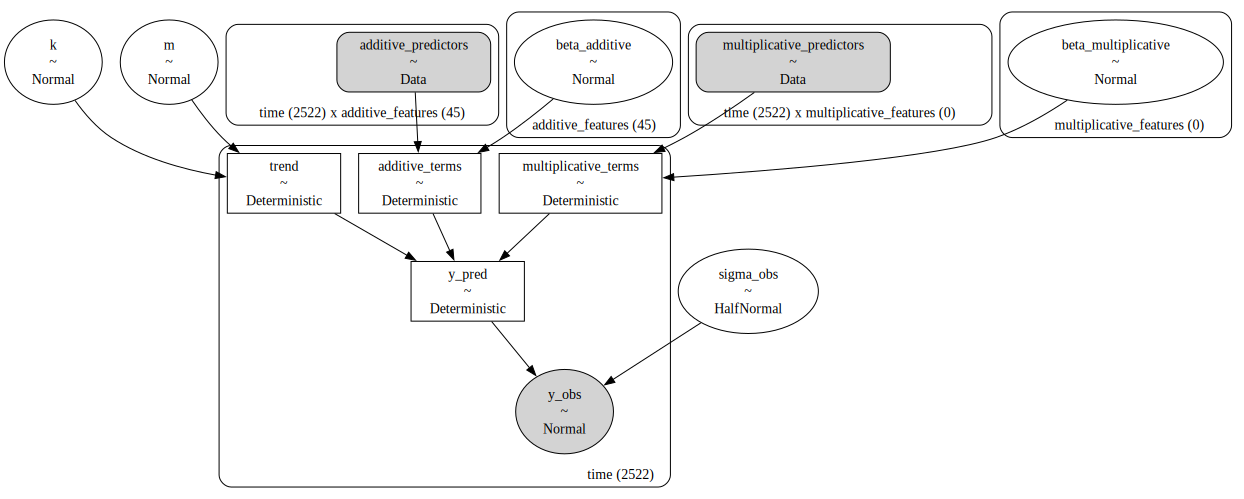

In [9]:
pm.model_to_graphviz(forecast_model)

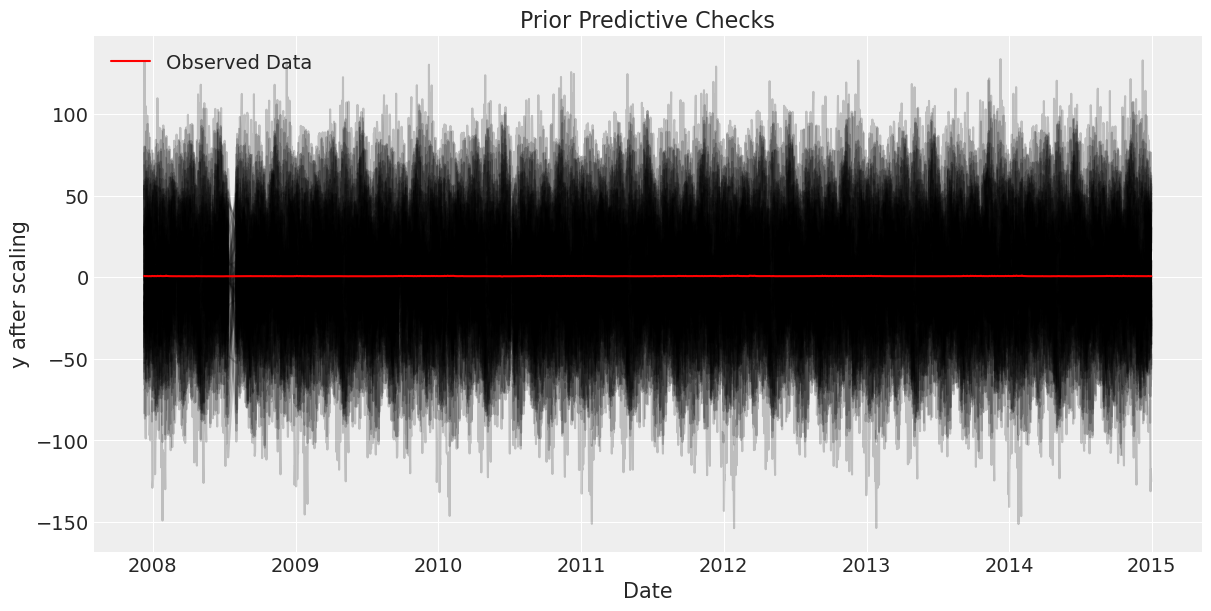

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted size

# Plot prior predictive samples
# ax.plot(idata.constant_data["time"], idata.prior["y_pred"].stack(sample=("chain", "draw")), c="k", alpha=0.2)
ax.plot(idata.constant_data["time"], idata.prior_predictive["y_obs"].stack(sample=("chain", "draw")), c="k", alpha=0.2)

# Plot actual observed data
ax.plot(idata.constant_data["time"], y, c="r", label="Observed Data")

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("y after scaling")
ax.set_title("Prior Predictive Checks")
ax.legend()
ax.grid(True)

plt.show()

### Prophet

In [14]:
prophet_model = Prophet(holidays=holidays)
prophet_model.add_country_holidays(country_name='US')
prophet_model.add_regressor('nfl_sunday')

In [15]:
transformed = prophet_model.preprocess(train_df)

In [16]:
transformed.t[75:85]

75    0.029480
76    0.029868
77    0.030256
78    0.030644
79    0.031420
80    0.032196
81    0.033359
82    0.033747
83    0.034135
84    0.034523
Name: t, dtype: float64

In [21]:
transformed.X

,yearly_delim_1,yearly_delim_2,yearly_delim_3,yearly_delim_4,yearly_delim_5,yearly_delim_6,yearly_delim_7,yearly_delim_8,yearly_delim_9,yearly_delim_10,...,New Year's Day_delim_+0,Thanksgiving_delim_+0,Veterans Day (observed)_delim_+0,Veterans Day_delim_+0,Washington's Birthday_delim_+0,playoff_delim_+0,playoff_delim_+1,superbowl_delim_+0,superbowl_delim_+1,nfl_sunday
0,-0.377462,0.926025,-0.699079,0.715044,-0.917267,0.398272,-0.999745,0.022576,-0.934311,-0.356460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.361478,0.932381,-0.674069,0.738668,-0.895501,0.445059,-0.995827,0.091261,-0.961479,-0.274879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.345386,0.938461,-0.648262,0.761418,-0.871351,0.490660,-0.987196,0.159513,-0.981538,-0.191266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.329192,0.944263,-0.621687,0.783266,-0.844881,0.534955,-0.973892,0.227011,-0.994341,-0.106239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.312900,0.949786,-0.594376,0.804187,-0.816160,0.577825,-0.955979,0.293434,-0.999791,-0.020426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,-0.090190,0.995925,-0.179645,0.983732,-0.267636,0.963520,-0.353445,0.935455,-0.436373,0.899766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2518,-0.073045,0.997329,-0.145700,0.989329,-0.217577,0.976043,-0.288291,0.957543,-0.357464,0.933927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2519,-0.055879,0.998438,-0.111583,0.993755,-0.166938,0.985967,-0.221772,0.975099,-0.275913,0.961183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2520,-0.038696,0.999251,-0.077334,0.997005,-0.115856,0.993266,-0.154204,0.988039,-0.192322,0.981332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
prophet_model = Prophet(holidays=holidays)
prophet_model.add_country_holidays(country_name='US')
prophet_model.add_regressor('nfl_sunday')
prophet_model.fit(train_df)

18:28:07 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
test_df['y']

2522     7.846590
2523     8.302018
2524     8.436200
2525     8.934587
2526     8.888619
          ...    
2900     7.817223
2901     9.273878
2902    10.333775
2903     9.125871
2904     8.891374
Name: y, Length: 383, dtype: float64

/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


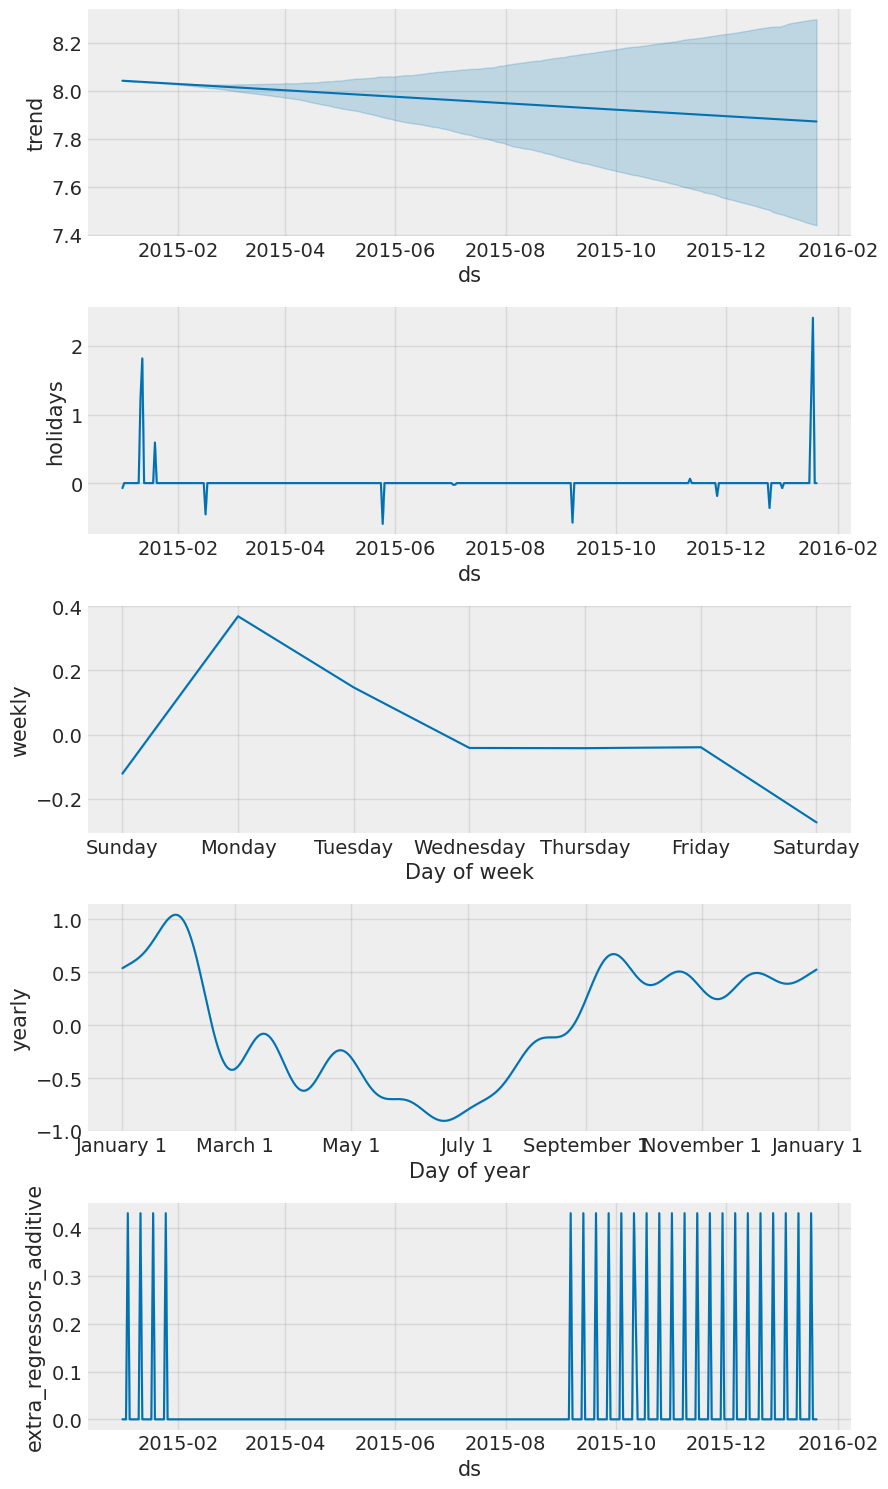

In [20]:
forecast = prophet_model.predict(test_df)
fig = prophet_model.plot_components(forecast)